<center><h1>Основы глубокого обучение</h1></center>

In [1]:
!python -V # Версия Python

Python 3.12.8


In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
import jupyterlab as jlab
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Matplotlib", "Yfinance", "Scikit-learn", "Ipywidgets", "JupyterLab"
]

package_objects = [
    torch, np, pl, pd, mpl, yf, sklearn, ipywidgets, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.2.2"""
2,"""NumPy""","""1.26.4"""
3,"""Polars""","""1.19.0"""
4,"""Pandas""","""2.2.3"""
5,"""Matplotlib""","""3.10.0"""
6,"""Yfinance""","""0.2.51"""
7,"""Scikit-learn""","""1.6.1"""
8,"""Ipywidgets""","""8.1.5"""
9,"""JupyterLab""","""4.3.4"""


# Лекция 4

4. **Современные архитектуры глубокого обучения**
    - Обзор семейства трансформеров
    - Применение данных архитектур для анализа последовательных данных, изображений и мультимодальной интеграции

## Трансформеры

### Описание
 
Трансформеры - это класс нейросетевых архитектур, впервые представленный в 2017 году на конференции NIPS [*Attention is All You Need* 2017](https://papers.nips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html). Они практически полностью изменили подход к обработке последовательных данных (например, в задачах обработки естественного языка) за счет использования механизма внимания, который позволяет моделям обрабатывать всю последовательность параллельно, в отличие от рекуррентных нейросетей

### Основные компоненты трансформера

1. **Входные эмбеддинги.** Отвечают за преобразование дискретных токенов (слов, пикселей) в непрерывное векторное пространство.
2. **Позиционные кодировки.** Отвечают за добавление информации о порядке элементов в последовательности, так как архитектура трансформера не обладает встроенным механизмом учета порядка.
3. **Многоголовое самовнимание (Multi-Head Self-Attention).** Позволяет модели уделять внимание различным частям входной последовательности, вычисляя несколько `голов` внимания параллельно.
4. **Полносвязные (Feed-Forward) слои.** Применяются к каждому элементу последовательности независимо после слоя внимания.
5. **Остаточные соединения и нормализация слоев.** Отвечают за стабилизацию обучения и улучшение распространения градиента.

### Детальный разбор компонентов трансформера

#### 1. Входные эмбеддинги для текста

**Описание:** Эмбеддинги - это способ преобразования дискретных токенов (например, слов, символов или даже пикселей) в непрерывные векторные представления. Это необходимо, поскольку нейросетям удобнее работать с числами, чем с текстовыми данными. Каждый токен преобразуется в вектор фиксированной размерности, который может нести в себе как синтаксическую, так и семантическую информацию.

**Что такое `словарь`:**  
- **Словарь (Vocabulary):** это множество всех уникальных токенов (слов, символов и т.д.), встречающихся в обучающем наборе данных
- **Индексация:** каждому токену из словаря присваивается уникальный числовой индекс. Например, если словарь содержит слово  
`школа` с индексом `2`, то при обработке текста слово `школа` будет представлено числом `2`


**Математическое объяснение:**

1. Пусть:
    - $V$ - размер словаря (общее число уникальных токенов)
    - $d$ - размерность эмбеддинга (количество чисел в векторе, которое представляет один токен)
2. Для представления всех токенов необходимо использовать **матрицу эмбеддингов** $\mathbf{E}$ размером:

$$
\mathbf{E} \in \mathbb{R}^{V \times d}
$$
    - Каждая строка этой матрицы соответствует векторному представлению одного токена из словаря
3. **Преобразование последовательности токенов.** Пусть дана последовательность токенов, представленных их индексами:  

$$
(i_1, i_2, \dots, i_n)
$$
    - Тогда эмбеддинг каждого токена $i_k$ - это вектор $E_{i_k}$ (выбранный из строки матрицы $\mathbf{E}$). Таким образом, входная матрица $X$ для модели будет выглядеть так:

$$
X = \begin{bmatrix}
E_{i_1} \\
E_{i_2} \\
\vdots \\
E_{i_n}
\end{bmatrix} \in \mathbb{R}^{n \times d}
$$

где $n$ - длина последовательности (например, число слов в предложении)

**Пример:** предположим, что есть словарь, состоящий из токенов:

```json
{"Высшая": 0, "школа": 1, "экономики": 2}
```

Если размерность эмбеддинга $d = 4$, то матрица эмбеддингов $\mathbf{E}$ может выглядеть абстрактно, так:

$$
\mathbf{E} = \begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\ % для слова "Высшая"
0.5 & 0.6 & 0.7 & 0.8 \\ % для слова "школа"
0.9 & 1.0 & 1.1 & 1.2 % для символа "экономики"
\end{bmatrix}
$$

Если обрабатывать предложение `Высшая школа экономики`, то последовательность индексов будет $(0, 1, 2)$, а эмбеддинговое представление:
$$
X = \begin{bmatrix}
E_0 \\
E_1 \\
E_2
\end{bmatrix} = \begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\
0.5 & 0.6 & 0.7 & 0.8 \\
0.9 & 1.0 & 1.1 & 1.2 \\
\end{bmatrix}
$$

*Пояснение:* размерность эмбеддинга $d = 4$ означает, что каждый токен - будь то слово или символ - представляется в виде вектора из 4 чисел. Это число не зависит от длины строки, из которой состоит токен. То есть:
- Слово `Высшая` может быть представлено вектором $[0.1, 0.2, 0.3, 0.4]$
- Слово `школа` - $[0.5, 0.6, 0.7, 0.8]$
- Символ `экономики` - $[0.9, 1.0, 1.1, 1.2]$

**Ключевой момент:** независимо от того, состоит ли токен из нескольких букв (как слово `Высшая`) или всего из одного символа (например знак `!`), каждому токену соответствует вектор фиксированной длины $d$. Это сделано для того, чтобы модель получала входы одинаковой размерности, что упрощает обработку и обучение. Таким образом у нас получается, что размер эмбеддинга - это гиперпараметр модели, определяющий размерность пространства, в котором токены `оживляются` числовыми векторами. Он не связан с числом символов в самом токене.

In [4]:
text = "Высшая школа экономики" # Исходный текст

# Токенизация текста (разбивка по пробелам)
tokens = text.split()  
print("Токены:", tokens) # Вывод: ['Высшая', 'школа', 'экономики']

# Автоматическая генерация словаря: сохранения порядка появления токенов в тексте и присваивание им уникальные индексы
vocab = {}
for token in tokens:
    if token not in vocab:
        vocab[token] = len(vocab)

print("Сгенерированный словарь:", vocab) # Вывод: {'Высшая': 0, 'школа': 1, 'экономики': 2}

# Преобразование токенов в индексы с использованием сгенерированного словаря
input_indices = [vocab[token] for token in tokens]
print("Индексы токенов:", input_indices) # Вывод: [0, 1, 2]

# Преобразование списка индексов в тензор PyTorch
input_tensor = torch.tensor(input_indices)
print("Тензор индексов:", input_tensor) # Вывод: tensor([0, 1, 2])

# Определение параметров эмбеддинга
vocab_size = len(vocab) # Количество уникальных токенов, здесь 3
embedding_dim = 4 # Размерность эмбеддинга: каждый токен представляется вектором из 4 чисел

# Создание слоя эмбеддингов
embedding_layer = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim)

# Получение эмбеддинговых векторов для входной последовательности
embeddings = embedding_layer(input_tensor)

print("Эмбеддинговое представление:")
print(embeddings)
print("Форма эмбеддингов:", embeddings.shape) # Размер: [3, 4]

Токены: ['Высшая', 'школа', 'экономики']
Сгенерированный словарь: {'Высшая': 0, 'школа': 1, 'экономики': 2}
Индексы токенов: [0, 1, 2]
Тензор индексов: tensor([0, 1, 2])
Эмбеддинговое представление:
tensor([[-0.7201,  0.6897,  0.1429, -0.5344],
        [ 1.2683,  0.9702, -1.3124,  0.0140],
        [ 0.0527, -0.0635, -0.5834, -1.4288]], grad_fn=<EmbeddingBackward0>)
Форма эмбеддингов: torch.Size([3, 4])


#### Входные эмбеддинги для изображений

**Описание:** в случае обработки изображений часто используется подход, при котором изображение разбивается на небольшие регионы - `патчи`, которые затем преобразуются в векторные представления. Каждый патч можно рассматривать как аналог токена в текстовых данных.

**Математическое объяснение:**

1. **Изображение:** пусть имеется изображение с размерами $H \times W$ и $C$ каналами. Оно представлено тензором:

$$
X \in \mathbb{R}^{C \times H \times W}
$$

2. **Разбиение на патчи:** изображение делится на непересекающиеся патчи размером $P \times P$. Общее число патчей будет:

$$
N = \frac{H \times W}{P^2}
$$

Каждый патч имеет размерность:

$$
\text{patch} \in \mathbb{R}^{C \times P \times P}
$$

При `развертке` патча в вектор его размер станет:

$$
C \times P^2
$$

3. **Линейная проекция (эмбеддинг):** для приведения размерности к фиксированному значению $d$ (гиперпараметр модели) можно применить обучаемую линейную проекцию:

$$
E_i = \text{flatten}(\text{patch}_i) \times W
$$

где $W \in \mathbb{R}^{(C \times P^2) \times d}$. В итоге получается матрица эмбеддингов для всех патчей:

$$
\mathbf{E} \in \mathbb{R}^{N \times d}
$$

**Пример:** предположим, что есть изображение с одним каналом (градация серого) размером $4 \times 4$. Это изображение можно представить в виде тензора:

$$
X \in \mathbb{R}^{1 \times 4 \times 4}
$$

Далее изображение делится на непересекающиеся патчи размером $2 \times 2$. При этом общее число патчей будет:

$$
N = \frac{4 \times 4}{2^2} = 4
$$

Каждый патч имеет исходную размерность:

$$
\text{patch} \in \mathbb{R}^{1 \times 2 \times 2}
$$

При `развертке` патча в вектор его размерность становится:

$$
1 \times 2 \times 2 = 4
$$

Чтобы привести все патчи к единой размерности, применяется обучаемая линейная проекция, которая отображает каждый вектор патча в пространство размерности эмбеддинга $d$. Если $d = 4$, то матрица эмбеддингов для патчей $\mathbf{E}$ может выглядеть абстрактно, так:

$$
\mathbf{E} = \begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\ % для первого патча
0.5 & 0.6 & 0.7 & 0.8 \\ % для второго патча
0.9 & 1.0 & 1.1 & 1.2 \\ % для третьего патча
1.3 & 1.4 & 1.5 & 1.6 \\ % для четвертого патча
\end{bmatrix}
$$

Если обрабатывать изображение, то последовательность патчей будет иметь индексы $(0, 1, 2, 3)$, а эмбеддинговое представление:

$$
X = \begin{bmatrix}
E_0 \\
E_1 \\
E_2 \\
E_3
\end{bmatrix} = \begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\
0.5 & 0.6 & 0.7 & 0.8 \\
0.9 & 1.0 & 1.1 & 1.2 \\
1.3 & 1.4 & 1.5 & 1.6 \\
\end{bmatrix}
$$

*Пояснение:*  
Размерность эмбеддинга $d = 4$ означает, что каждый патч изображения (аналог токена в текстовых данных) представляется в виде вектора из 4 чисел. Это фиксированная размерность, выбранная как гиперпараметр модели, и она не зависит от исходного размера патча (например, $2 \times 2$ пикселей). После линейной проекции каждый патч `оживляется` вектором фиксированной размерности, что позволяет модели обрабатывать патчи как однородные входы

In [5]:
# Создание изображения с 1 каналом размером 4x4
# Заполнение изображения последовательными числами от 1 до 16
C, H, W = 1, 4, 4
image = torch.arange(1, 1 + C * H * W, dtype = torch.float).reshape(C, H, W)

# Вывод:
# tensor([[[ 1.,  2.,  3.,  4.],
#          [ 5.,  6.,  7.,  8.],
#          [ 9., 10., 11., 12.],
#          [13., 14., 15., 16.]]])
print("Исходное изображение:\n", image)

# Определение размера патча (например, 2x2)
patch_size = 2

# Разбиение изображения на патчи с помощью метода unfold
# Сначала разворачивается по высоте (dimension = 1), затем по ширине (dimension = 2)
patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)

# Вывод: [1, 2, 2, 2, 2]
# - 1: число каналов
# - 2: число патчей по высоте (4 / 2 = 2)
# - 2: число патчей по ширине (4 / 2 = 2)
# - 2,2: размер каждого патча
print("Форма тензора патчей:", patches.shape)

# Преобразование патчей в набор векторов:
# 1. Объединение размер патча (2x2) в один вектор: размер 1*2*2 = 4
# 2. Переставление оси так, чтобы получить форму [N, 4], где N = 2*2 = 4 патча
patches = patches.contiguous().view(C, -1, patch_size * patch_size) # [1, N, 4]
patches = patches.squeeze(0) # Удаление измерения канала, если оно равно 1

# Вывод: [4, 4] - 4 патча, каждый представлен вектором из 4 чисел
print("Форма патчей после преобразования:", patches.shape)

# Задание размерности эмбеддинга, d
d = 4 # Каждый патч будет проецирован в вектор фиксированной размерности 4

# Определение обучаемой линейной проекции для преобразования векторов патчей
# из размерности 4 (из patch_size*patch_size) в размерность эмбеддинга d
proj = nn.Linear(patch_size * patch_size, d)

# Применение линейной проекции к каждому патчу
patch_embeddings = proj(patches)

print("Эмбеддинговое представление патчей:\n", patch_embeddings)
# Вывод: [4, 4], где каждая строка соответствует вектору-эмбеддингу одного патча
print("Форма эмбеддингов патчей:", patch_embeddings.shape)

Исходное изображение:
 tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]])
Форма тензора патчей: torch.Size([1, 2, 2, 2, 2])
Форма патчей после преобразования: torch.Size([4, 4])
Эмбеддинговое представление патчей:
 tensor([[ 1.8766,  1.3201, -1.5771,  0.6956],
        [ 2.2866,  1.8264, -2.7446,  1.0108],
        [ 3.5165,  3.3453, -6.2468,  1.9562],
        [ 3.9264,  3.8517, -7.4142,  2.2714]], grad_fn=<AddmmBackward0>)
Форма эмбеддингов патчей: torch.Size([4, 4])


#### 2. Позиционные кодировки в трансформерах

Трансформеры не используют рекуррентные или сверточные связи, поэтому они **не имеют информации о порядке элементов** во входной последовательности. Чтобы передавать эту информацию, используется **позиционное кодирование** (Positional Encoding)

##### Зачем нужны позиционные кодировки?

Когда слова (или патчи изображения) преобразуются в эмбеддинги, модель получает **набор векторов без структуры**. Например, предложение:

`Высшая школа экономики` -> $[E_0, E_1, E_2]$

Модель **не знает**, что слово `Высшая` стоит первым, а `экономики` — третьим

**Решение:** добавить к каждому эмбеддингу вектор, который кодирует позицию токена в последовательности. Итоговый вход в модель получается как сумма эмбеддинга и позиционного вектора:
  
$$
\widetilde{E}_k = E_k + PE(k)
$$

где $k$ - позиция токена

##### Формулы синусоидальных позиционных кодировок

Позиционные кодировки генерируются с помощью **синусоидальных функций** разной частоты:

$$
PE(pos, 2i) = \sin \left(\frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

$$
PE(pos, 2i+1) = \cos \left(\frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

где:  
- $pos$ - индекс токена в последовательности ($0, 1, 2, \dots$)
- $d$ - размерность эмбеддинга
- $i$ - индекс измерения внутри вектора эмбеддинга

Эти формулы позволяют задать уникальное представление для каждой позиции, при этом расстояние между позициями может быть интерпретировано через линейные комбинации синусов и косинусов

##### Пример использования позиционных кодировок к тексту

Предположим, что уже есть эмбеддинги для слов `Высшая школа экономики`, полученные на предыдущем этапе (например, после слоя эмбеддингов):

Их токенизация и преобразование в индексы дает последовательность $(0, 1, 2)$. А эмбеддинговое представление (например, после слоя эмбеддингов):

$$
X = \begin{bmatrix}
E_0 \\
E_1 \\
E_2
\end{bmatrix} =
\begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\
0.5 & 0.6 & 0.7 & 0.8 \\
0.9 & 1.0 & 1.1 & 1.2 \\
\end{bmatrix}
$$

Где каждый $E_k$ ($k = 0, 1, 2$) - это вектор размерности $d = 4$

Чтобы модель могла учитывать порядок токенов, добавляются позиционные кодировки, вычисляемые по формулам:

$$
PE(pos, 2i) = \sin \left(\frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

$$
PE(pos, 2i+1) = \cos \left(\frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

*Примечание.* Почему используются синус и косинус?
- **Моделирование зависимостей**:
    - Разные частоты позволяют кодировать как близкие, так и дальние зависимости между токенами
    - Меньшие значения i<sub>д</sub> дают высокочастотные колебания (акцент на различиях между соседними токенами)
    - Большие значения i<sub>д</sub> дают низкочастотные колебания (захват различий между далекими токенами)
- **Устойчивость к масштабированию**:
    - Преобразования сохраняют свойства при изменении масштаба
    - Естественное масштабирование для последовательностей разной длины
- **Сохранение позиционной информации**:
    - Линейные операции сохраняют относительные позиции
    - *Ключевое свойство*: разность двух позиций pos<sub>1</sub> и pos<sub>2</sub> может быть выражена как линейная комбинация синусоидальных функций

Таким образом пример вычисления для $d = 4$:
- Для $pos = 0$ (первый токен):
    - $PE(0, 0) = \sin(0) = 0$
    - $PE(0, 1) = \cos(0) = 1$
    - $PE(0, 2) = \sin(0) = 0$
    - $PE(0, 3) = \cos(0) = 1$
  
    Выход: $PE(0) = [0, \;1,\; 0,\; 1]$

    *Примечание.* Когда $pos = 0$, то знаменатель внутри синуса и косинуса не имеет значения, поскольку числитель равен нулю. То есть для любого $i$ выполняется:

$$
\frac{0}{10000^{\frac{2i}{d}}} = 0
$$

Следовательно:
- $\sin(0) = 0$
- $\cos(0) = 1$

- Для $pos = 1$ (второй токен):
    - $PE(1, 0) = \sin\left(\frac{1}{10000^{\frac{0}{4}}}\right) = \sin(1) \approx 0.8415$
    - $PE(1, 1) = \cos(1) \approx 0.5403$
    - $PE(1, 2) = \sin\left(\frac{1}{10000^{\frac{2}{4}}}\right) = \sin\left(\frac{1}{100}\right) \approx 0.01$
    - $PE(1, 3) = \cos\left(\frac{1}{100}\right) \approx 0.99995$

    Выход: $PE(1) \approx [0.8415,\; 0.5403,\; 0.01,\; 0.99995]$

- Для $pos = 2$ (третий токен):
    - $PE(2, 0) = \sin(2) \approx 0.9093$
    - $PE(2, 1) = \cos(2) \approx -0.4161$
    - $PE(2, 2) = \sin\left(\frac{2}{100}\right) \approx 0.02$
    - $PE(2, 3) = \cos\left(\frac{2}{100}\right) \approx 0.9998$

    Выход: $PE(2) \approx [0.9093,\; -0.4161,\; 0.02,\; 0.9998]$

Далее итоговое представление для каждого токена получается суммированием его эмбеддинга и соответствующей позиционной кодировки:

$$
\widetilde{E}_k = E_k + PE(k)
$$

Выход:
- Для токена 0 (слово `Высшая`):

$$
\widetilde{E}_0 = [0.1+0,\; 0.2+1,\; 0.3+0,\; 0.4+1] = [0.1,\; 1.2,\; 0.3,\; 1.4]
$$

- Для токена 1 (слово `школа`):

$$
\widetilde{E}_1 \approx [0.5+0.8415,\; 0.6+0.5403,\; 0.7+0.01,\; 0.8+0.99995] \approx [1.3415,\; 1.1403,\; 0.71,\; 1.79995]
$$

- Для токена 2 (слово `экономики`):

$$
\widetilde{E}_2 \approx [0.9+0.9093,\; 1.0-0.4161,\; 1.1+0.02,\; 1.2+0.9998] \approx [1.8093,\; 0.5839,\; 1.12,\; 2.1998]
$$

После вычисления позиционных кодировок и добавления их к эмбеддингам для каждого токена, итоговое представление выглядит:

$$
\widetilde{X} = \begin{bmatrix}
\widetilde{E}_0 \\
\widetilde{E}_1 \\
\widetilde{E}_2 \\
\end{bmatrix}
$$

где

- $\widetilde{E}_0 = E_0 + PE(0)$ - для первого токена (например, `Высшая`)
- $\widetilde{E}_1 = E_1 + PE(1)$ - для второго токена (например, `школа`)
- $\widetilde{E}_2 = E_2 + PE(2)$ - для третьего токена (например, `экономики`)

Это позволяет модели учитывать не только содержимое каждого слова, но и их порядок в предложении, что особенно важно для понимания синтаксических и семантических отношений в тексте

In [6]:
def positional_encoding(seq_len, d_model):
    PE = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

    # Заполнение четных индексов синусами и нечетных - косинусами
    PE[:, 0::2] = torch.sin(position * div_term)
    PE[:, 1::2] = torch.cos(position * div_term)

    return PE

# Эмбеддинговое представление для предложения "Высшая школа экономики"
X = torch.tensor([
    [0.1, 0.2, 0.3, 0.4], # E_0 для "Высшая"
    [0.5, 0.6, 0.7, 0.8], # E_1 для "школа"
    [0.9, 1.0, 1.1, 1.2] # E_2 для "экономики"
])

seq_len = X.shape[0] # 3 токена
d_model = X.shape[1] # размерность эмбеддинга 4

# Вычисление позиционных кодировок для 3 позиций
PE = positional_encoding(seq_len, d_model)
print("Позиционные кодировки:")
print(PE)

# Итоговое представление: сумма эмбеддингов и их позиционных кодировок
X_pos = X + PE
print("\nЭмбеддинговое представление с позиционными кодировками:")
print(X_pos)

Позиционные кодировки:
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  1.0000],
        [ 0.9093, -0.4161,  0.0200,  0.9998]])

Эмбеддинговое представление с позиционными кодировками:
tensor([[0.1000, 1.2000, 0.3000, 1.4000],
        [1.3415, 1.1403, 0.7100, 1.8000],
        [1.8093, 0.5839, 1.1200, 2.1998]])


##### Пример использования позиционных кодировок для изображения

Предположим, что после разбиения изображения на патчи и их обработки (например, линейной проекцией) получено следующее эмбеддинговое представление патчей:

$$
X = \begin{bmatrix}
E_0 \\
E_1 \\
E_2 \\
E_3
\end{bmatrix} =
\begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\
0.5 & 0.6 & 0.7 & 0.8 \\
0.9 & 1.0 & 1.1 & 1.2 \\
1.3 & 1.4 & 1.5 & 1.6 \\
\end{bmatrix}
$$

где каждый $E_k$ ($k = 0, 1, 2, 3$) является вектором размерности $d = 4$

Чтобы модель могла учитывать положение патчей в изображении (например, для Vision Transformer), вычисляются позиционные кодировки по тем же формулам:

$$
PE(pos, 2i) = \sin \left(\frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

$$
PE(pos, 2i+1) = \cos \left(\frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

Таким образом пример вычисления для $d = 4$:

- Для $pos = 0$ (первый патч):
    - $PE(0, 0) = \sin(0) = 0$
    - $PE(0, 1) = \cos(0) = 1$
    - $PE(0, 2) = \sin(0) = 0$
    - $PE(0, 3) = \cos(0) = 1$
  
    Выход: $PE(0) = [0,\; 1,\; 0,\; 1]$

- Для $pos = 1$ (второй патч):
    - $PE(1, 0) = \sin(1) \approx 0.8415$
    - $PE(1, 1) = \cos(1) \approx 0.5403$
    - $PE(1, 2) = \sin\left(\frac{1}{100}\right) \approx 0.01$
    - $PE(1, 3) = \cos\left(\frac{1}{100}\right) \approx 0.99995$
  
    Выход: $PE(1) \approx [0.8415,\; 0.5403,\; 0.01,\; 0.99995]$

- Для $pos = 2$ (третий патч):
    - $PE(2, 0) = \sin(2) \approx 0.9093$
    - $PE(2, 1) = \cos(2) \approx -0.4161$
    - $PE(2, 2) = \sin\left(\frac{2}{100}\right) \approx 0.02$
    - $PE(2, 3) = \cos\left(\frac{2}{100}\right) \approx 0.9998$
  
    Выход: $PE(2) \approx [0.9093,\; -0.4161,\; 0.02,\; 0.9998]$

- Для $pos = 3$ (четвертый патч):
    - $PE(3, 0) = \sin(3) \approx 0.1411$
    - $PE(3, 1) = \cos(3) \approx -0.99$
    - $PE(3, 2) = \sin\left(\frac{3}{100}\right) \approx 0.03$
    - $PE(3, 3) = \cos\left(\frac{3}{100}\right) \approx 0.99955$
  
    Выход: $PE(3) \approx [0.1411,\; -0.99,\; 0.03,\; 0.99955]$

Далее итоговое представление для каждого патча получается суммированием его эмбеддинга и соответствующей позиционной кодировки:

$$
\widetilde{E}_k = E_k + PE(k)
$$

Выход:

- Для патча 0:

$$
\widetilde{E}_0 = [0.1+0,\; 0.2+1,\; 0.3+0,\; 0.4+1] = [0.1,\; 1.2,\; 0.3,\; 1.4]
$$

- Для патча 1:

$$
\widetilde{E}_1 \approx [0.5+0.8415,\; 0.6+0.5403,\; 0.7+0.01,\; 0.8+0.99995] \approx [1.3415,\; 1.1403,\; 0.71,\; 1.79995]
$$

- Для патча 2:

$$
\widetilde{E}_2 \approx [0.9+0.9093,\; 1.0-0.4161,\; 1.1+0.02,\; 1.2+0.9998] \approx [1.8093,\; 0.5839,\; 1.12,\; 2.1998]
$$

- Для патча 3:

$$
\widetilde{E}_3 \approx [1.3+0.1411,\; 1.4-0.99,\; 1.5+0.03,\; 1.6+0.99955] \approx [1.4411,\; 0.41,\; 1.53,\; 2.59955]
$$

Итоговое эмбеддинговое представление с добавленными позиционными кодировками для изображения:

$$
\widetilde{X} = \begin{bmatrix}
\widetilde{E}_0 \\
\widetilde{E}_1 \\
\widetilde{E}_2 \\
\widetilde{E}_3 \\
\end{bmatrix}
$$

где

- $\widetilde{E}_0 = E_0 + PE(0)$ - для первого патча (например, верхний левый)
- $\widetilde{E}_1 = E_1 + PE(1)$ - для второго патча (например, верхний правый)
- $\widetilde{E}_2 = E_2 + PE(2)$ - для третьего патча (например, нижний левый)
- $\widetilde{E}_3 = E_3 + PE(3)$ - для четвертого патча (например, нижний правый)


Это позволяет модели учитывать не только содержимое каждого патча, но и их положение в изображении, что особенно важно для пространственной структуры данных, как в Vision Transformer

In [7]:
def positional_encoding(seq_len, d_model):
    PE = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Форма: [seq_len, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    
    # Заполнение четных индексов синусами и нечетных - косинусами
    PE[:, 0::2] = torch.sin(position * div_term)
    PE[:, 1::2] = torch.cos(position * div_term)

    return PE

# Эмбеддинговое представление патчей изображения (4 патча)
X = torch.tensor([
    [0.1, 0.2, 0.3, 0.4], # E_0 для первого патча (например, верхний левый)
    [0.5, 0.6, 0.7, 0.8], # E_1 для второго патча (например, верхний правый)
    [0.9, 1.0, 1.1, 1.2], # E_2 для третьего патча (например, нижний левый)
    [1.3, 1.4, 1.5, 1.6] # E_3 для четвертого патча (например, нижний правый)
], dtype = torch.float)

seq_len = X.shape[0] # Количество патчей (4)
d_model = X.shape[1] # Размерность эмбеддинга (4)

# Вычисление позиционных кодировок для 4 патчей
PE = positional_encoding(seq_len, d_model)
print("Позиционные кодировки для каждого патча:")
print(PE)

# Итоговое представление для каждого патча: сумма эмбеддинга и позиционной кодировки
X_pos = X + PE
print("\nЭмбеддинговое представление с добавленными позиционными кодировками:")
print(X_pos)

Позиционные кодировки для каждого патча:
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  1.0000],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996]])

Эмбеддинговое представление с добавленными позиционными кодировками:
tensor([[0.1000, 1.2000, 0.3000, 1.4000],
        [1.3415, 1.1403, 0.7100, 1.8000],
        [1.8093, 0.5839, 1.1200, 2.1998],
        [1.4411, 0.4100, 1.5300, 2.5996]])


#### 3. Многоголовое самовнимание (Multi-Head Self-Attention)

Ключевой механизм в архитектуре трансформеров, который позволяет модели учитывать взаимосвязи между всеми элементами входной последовательности, распределяя внимание по разным `головам`. Каждая голова обучается фокусироваться на различных аспектах взаимосвязей, что в сумме дает более большое представление данных

##### Основная идея

Пусть на входе имеется матрица эмбеддингов с добавленными позиционными кодировками:

$$
\widetilde{X} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_{\text{model}}}
$$

Для вычисления самовнимания необходимо получить три матрицы:
- **Запросы (Queries):** $Q = \widetilde{X}W_Q$
- **Ключи (Keys):** $K = \widetilde{X}W_K$
- **Значения (Values):** $V = \widetilde{X}W_V$

где $W_Q, W_K, W_V \in \mathbb{R}^{d_{\text{model}} \times d_k}$ - обучаемые весовые матрицы, а $d_k$ обычно определяется как $d_{\text{model}}/h$ при использовании $h$ голов

Эти вычисления применяются по следующим причинам:

1. **Разделение ролей для разных аспектов информации:** Каждый токен в последовательности представлен его эмбеддингом в матрице $\widetilde{X}$. Однако для механизма внимания требуется разделить эту информацию на три части:
    - **Запрос (Query):** Вектор, который определяет, какую информацию ищет данный токен. Он задает `вопрос`, на который необходимо получить ответ
    - **Ключ (Key):** Вектор, который содержит информацию о том, что представлено в каждом токене. Служит `меткой`, позволяющей сравнить, насколько содержимое токена релевантно запросу
    - **Значение (Value):** Вектор, содержащий `содержимое`, которое будет использовано для формирования итогового представления. Это именно та информация, которая будет агрегирована в результате внимания
2. **Линейные преобразования для выделения признаков:**
   Применяя разные обучаемые весовые матрицы $W_Q$, $W_K$ и $W_V$ к входной матрице $\widetilde{X}$, модель учится извлекать различные аспекты информации:
    - $W_Q$: Позволяет выделить те признаки, которые важны для формирования запроса - что именно ищет токен
    - $W_K$: Выделяет признаки, необходимые для представления содержания токена, по которым будет проводиться сравнение с запросом
    - $W_V$: Определяет, какая информация (значения) должна быть передана дальше, если запрос находит соответствие в ключах
   
Таким образом, каждое из этих преобразований позволяет модели адаптировать представление входных данных под конкретную роль (запрос, ключ или значение)

3. **Гибкость и обучаемость:**
   Использование обучаемых матриц $W_Q$, $W_K$ и $W_V$ дает модели возможность динамически оптимизировать процесс извлечения информации из эмбеддингов. Вместо того чтобы использовать одно и то же представление для всех трех функций, модель может обучаться выделять разные аспекты информации, что существенно улучшает качество вычисляемого внимания
4. **Механизм внимания:**
   После вычисления $Q$ и $K$ происходит сравнение (например, через скалярное произведение), что позволяет модели определить, насколько каждый токен релевантен другому. Взвешенное суммирование значений $V$ на основе этих оценок дает итоговое представление, где каждый токен `смотрит` на другие токены в последовательности

Таким образом, использование линейных проекций:

$$
Q = \widetilde{X}W_Q,\quad K = \widetilde{X}W_K,\quad V = \widetilde{X}W_V
$$

позволяет модели эффективно разделять роли и извлекать необходимые признаки из исходных эмбеддингов для успешного вычисления механизма внимания.

##### Механизм внимания для одной головы

Для одной головы внимание вычисляется следующим образом:

1. Вычисление скоринговой матрицы:

$$
\text{scores} = \frac{QK^T}{\sqrt{d_k}}
$$

2. Применение softmax для получения весов внимания:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\text{scores}) \times V
$$

Формула $\frac{1}{\sqrt{d_k}}$ нужна для стабилизации градиентов, особенно когда $d_k$ велико

##### Многоголовое внимание

Вместо того, чтобы вычислять внимание только один раз, многоголовое внимание разделяет пространство представлений на $h$ частей. Для каждой головы $i$ выполняются следующие шаги:

1. Линейные проекции для каждой головы:

$$
Q_i = \widetilde{X}W^Q_i,\quad K_i = \widetilde{X}W^K_i,\quad V_i = \widetilde{X}W^V_i
$$
   
где $W^Q_i, W^K_i, W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$

2. Вычисление внимания для каждой головы:

$$
\text{head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}\!\left(\frac{Q_i K_i^T}{\sqrt{d_k}}\right) V_i
$$

3. Объединение результатов всех голов и финальная линейная проекция:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O
$$
   
где $W^O \in \mathbb{R}^{(h \times d_k) \times d_{\text{model}}}$ - обучаемая матрица проекции

##### Пример применения многоголового внимания к тексту после позиционных кодировок

Пусть есть матрица эмбеддингов с позиционными кодировками $\widetilde{X} \in \mathbb{R}^{3 \times 4}$:

$$
\widetilde{X} = \begin{bmatrix}
0.1000 & 1.2000 & 0.3000 & 1.4000 \\
1.3415 & 1.1403 & 0.7100 & 1.8000 \\
1.8093 & 0.5839 & 1.1200 & 2.1998
\end{bmatrix}
$$

Необходимо использовать многоголовое внимание с $h = 2$ головами. Размерность входного эмбеддинга $d_{model} = 4$, а размерность каждой головы $d_k = \frac{d_{model}}{h} = 2$

Вычисление матриц $Q$, $K$, $V$

Матрицы параметров:

$$
W_Q^{(i)}, W_K^{(i)}, W_V^{(i)} \in \mathbb{R}^{d_{model} \times d_k}
$$

Параметры для первой головы

Матрицы весов:

$$
W_Q^{(1)} = \begin{bmatrix} 0.2 & 0.3 \\ 0.4 & 0.5 \\ 0.6 & 0.7 \\ 0.8 & 0.9 \end{bmatrix},
W_K^{(1)} = \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \\ 0.5 & 0.6 \\ 0.7 & 0.8 \end{bmatrix},
W_V^{(1)} = \begin{bmatrix} 0.9 & 0.8 \\ 0.7 & 0.6 \\ 0.5 & 0.4 \\ 0.3 & 0.2 \end{bmatrix}
$$

Вычисление $Q^{(1)}$, $K^{(1)}$, $V^{(1)}$:

$$
Q^{(1)} = \widetilde{X} W_Q^{(1)}
$$

$$
K^{(1)} = \widetilde{X} W_K^{(1)}
$$

$$
V^{(1)} = \widetilde{X} W_V^{(1)}
$$

Вычисление $Q^{(1)}$

$$
Q^{(1)} = \begin{bmatrix} 0.1000 & 1.2000 & 0.3000 & 1.4000 \\
1.3415 & 1.1403 & 0.7100 & 1.8000 \\
1.8093 & 0.5839 & 1.1200 & 2.1998 \end{bmatrix}
\begin{bmatrix} 0.2 & 0.3 \\ 0.4 & 0.5 \\ 0.6 & 0.7 \\ 0.8 & 0.9 \end{bmatrix}
$$

Поэлементное умножение и суммирование:

$$
Q^{(1)} = \begin{bmatrix}
(0.1 \times 0.2 + 1.2 \times 0.4 + 0.3 \times 0.6 + 1.4 \times 0.8) & (0.1 \times 0.3 + 1.2 \times 0.5 + 0.3 \times 0.7 + 1.4 \times 0.9) \\
(1.3415 \times 0.2 + 1.1403 \times 0.4 + 0.7100 \times 0.6 + 1.8 \times 0.8) & (1.3415 \times 0.3 + 1.1403 \times 0.5 + 0.7100 \times 0.7 + 1.8 \times 0.9) \\
(1.8093 \times 0.2 + 0.5839 \times 0.4 + 1.1200 \times 0.6 + 2.1998 \times 0.8) & (1.8093 \times 0.3 + 0.5839 \times 0.5 + 1.1200 \times 0.7 + 2.1998 \times 0.9)
\end{bmatrix}
$$

Выход:

$$
Q^{(1)} = \begin{bmatrix} 1.52 & 1.89 \\
1.9826 & 2.4820 \\
1.9789 & 2.6263 \end{bmatrix}
$$

Аналогично вычисляются $K^{(1)}$ и $V^{(1)}$

Используя те же входные данные $\widetilde{X}$ и заданные матрицы весов для первой головы, вычисляется матрица ключей $K^{(1)}$:

$$
W_K^{(1)} = \begin{bmatrix} 
0.1 & 0.2 \\[5pt]
0.3 & 0.4 \\[5pt]
0.5 & 0.6 \\[5pt]
0.7 & 0.8 
\end{bmatrix}
$$
  
Выход:
  
$$
K^{(1)} = \widetilde{X} \, W_K^{(1)}
$$
  
Пример расчета для первой строки:
  
$$
x_0 = [0.1000,\; 1.2000,\; 0.3000,\; 1.4000]
$$
  
Тогда первый элемент $K^{(1)}_{0,0}$ рассчитывается как:
  
$$
K^{(1)}_{0,0} = 0.1000\times0.1 + 1.2000\times0.3 + 0.3000\times0.5 + 1.4000\times0.7
$$
  
$$
= 0.0100 + 0.3600 + 0.1500 + 0.9800 = 1.5000
$$
  
Первый элемент второй координаты:
  
$$
K^{(1)}_{0,1} = 0.1000\times0.2 + 1.2000\times0.4 + 0.3000\times0.6 + 1.4000\times0.8
$$
  
$$
= 0.0200 + 0.4800 + 0.1800 + 1.1200 = 1.8000
$$
  
Таким образом, первая строка $K^{(1)}$ равна $[1.5000,\; 1.8000]$. Аналогичным образом вычисляются остальные строки, и выход будет:
  
$$
K^{(1)} = \begin{bmatrix} 
1.5000 & 1.8000 \\[5pt]
2.0912 & 2.5904 \\[5pt]
2.4560 & 3.0273 
\end{bmatrix}
$$

Матрица значений $V^{(1)}$
  
$$
W_V^{(1)} = \begin{bmatrix} 
0.9 & 0.8 \\[5pt]
0.7 & 0.6 \\[5pt]
0.5 & 0.4 \\[5pt]
0.3 & 0.2 
\end{bmatrix}
$$
  
Выход:

$$
V^{(1)} = \widetilde{X} \, W_V^{(1)}
$$
  
Пример расчета для первой строки:
  
Для $x_0 = [0.1000,\; 1.2000,\; 0.3000,\; 1.4000]$:
  
$$
V^{(1)}_{0,0} = 0.1000\times0.9 + 1.2000\times0.7 + 0.3000\times0.5 + 1.4000\times0.3
$$
  
$$
= 0.0900 + 0.8400 + 0.1500 + 0.4200 = 1.5000
$$
  
$$
V^{(1)}_{0,1} = 0.1000\times0.8 + 1.2000\times0.6 + 0.3000\times0.4 + 1.4000\times0.2
$$
  
$$
= 0.0800 + 0.7200 + 0.1200 + 0.2800 = 1.2000
$$
  
Таким образом, первая строка $V^{(1)}$ равна $[1.5000,\; 1.2000]$. Остальные строки вычисляются аналогично, и итоговая матрица:
  
$$
V^{(1)} = \begin{bmatrix} 
1.5000 & 1.2000 \\[5pt]
2.8906 & 2.4014 \\[5pt]
3.2570 & 2.6857 
\end{bmatrix}
$$

**Процесс вычисления внимания**

1. Оценка сходства токенов через скалярное произведение

Вычисление матрицы сходства $S$ для первой головы с помощью формулы:

$$
S = \frac{Q^{(1)} (K^{(1)})^T}{\sqrt{d_k}}
$$

где $d_k = 2$ и $\sqrt{2} \approx 1.414$

Матрицы:

$$
Q^{(1)} = \begin{bmatrix} 
1.5200 & 1.8900 \\[5pt]
1.9826 & 2.4820 \\[5pt]
1.9789 & 2.6263 
\end{bmatrix}, \quad
K^{(1)} = \begin{bmatrix} 
1.5000 & 1.8000 \\[5pt]
2.0912 & 2.5904 \\[5pt]
2.4560 & 3.0273 
\end{bmatrix}
$$

Вычисление элемента $(i,j)$ матрицы $Q^{(1)}(K^{(1)})^T$

Для $i = 1,\, j = 1$

$$
S_{1,1} = \frac{1.5200 \times 1.5000 + 1.8900 \times 1.8000}{1.414}
$$
  
$$
= \frac{2.2800 + 3.4020}{1.414} = \frac{5.6820}{1.414} \approx 4.02
$$
  
Для $i = 1,\, j = 2$

$$
S_{1,2} = \frac{1.5200 \times 2.0912 + 1.8900 \times 2.5904}{1.414} \approx \frac{3.178 + 4.900}{1.414} \approx \frac{8.078}{1.414} \approx 5.72
$$
  
Для $i = 1,\, j = 3$

$$
S_{1,3} = \frac{1.5200 \times 2.4560 + 1.8900 \times 3.0273}{1.414} \approx \frac{3.733 + 5.722}{1.414} \approx \frac{9.455}{1.414} \approx 6.69
$$
  
Аналогичные расчеты проводятся для остальных элементов, и итоговая матрица сходства имеет вид:

$$
S \approx \begin{bmatrix}
4.02 & 5.72 & 6.69 \\
5.73 & 8.18 & 9.35 \\
5.64 & 8.03 & 9.18
\end{bmatrix}
$$

2. Применение функции softmax

Применяется softmax по строкам для получения матрицы весов внимания $A$

$$
A = \text{softmax}(S)
$$

Например, для первой строки $S_1 = [4.02, 5.72, 6.69]$ softmax выдаст приближенное распределение

$$
A_1 \approx [0.10,\, 0.30,\, 0.60]
$$

Аналогично, для остальных строк:

$$
A \approx \begin{bmatrix}
0.10 & 0.30 & 0.60 \\
0.12 & 0.33 & 0.55 \\
0.11 & 0.32 & 0.57
\end{bmatrix}
$$

3. Вычисление выходного представления для первой головы

$$
Z^{(1)} = A V^{(1)}
$$

где

$$
V^{(1)} = \begin{bmatrix}
1.5000 & 1.2000 \\
2.8906 & 2.4014 \\
3.2570 & 2.6857
\end{bmatrix}
$$

Пример вычисления для первой строки:

$$
Z^{(1)}_0 = 0.10 \times [1.5000,\; 1.2000] + 0.30 \times [2.8906,\; 2.4014] + 0.60 \times [3.2570,\; 2.6857]
$$

- Первый элемент:

$$
0.10 \times 1.5000 = 0.1500 \\
0.30 \times 2.8906 \approx 0.8672 \\
0.60 \times 3.2570 \approx 1.9542 \\
\text{Сумма} \approx 0.1500 + 0.8672 + 1.9542 = 2.9714
$$

- Второй элемент:

$$
0.10 \times 1.2000 = 0.1200 \\
0.30 \times 2.4014 \approx 0.7204 \\
0.60 \times 2.6857 \approx 1.6114 \\
\text{Сумма} \approx 0.1200 + 0.7204 + 1.6114 = 2.4518
$$

Таким образом, первая строка $Z^{(1)}_0 \approx [2.9714,\; 2.4518]$. Остальные строки вычисляются аналогичным образом, получая итоговую матрицу $Z^{(1)}$

##### Объединение всех голов и финальная линейная проекция

Если используется более одной головы (например, $h=2$), то выходы каждой головы $Z^{(1)}$ и $Z^{(2)}$ конкатенируются:

$$
Z = \text{Concat}(Z^{(1)}, Z^{(2)}) \in \mathbb{R}^{3 \times (2 \cdot d_k)} = \mathbb{R}^{3 \times 4}
$$

После этого применяется финальная линейная проекция с матрицей $W_O \in \mathbb{R}^{d_{model} \times d_{model}}$:

$$
\text{Output} = Z W_O
$$

Эта операция преобразует объединенное представление в итоговое пространство размерности $d_{model}$, которое будет использоваться в последующих слоях трансформера

##### Итог

Таким образом, механизм многоголового внимания выполняет следующие шаги:
1. **Вычисление $Q$, $K$, $V$:** Каждый токен представляется в виде запроса, ключа и значения с помощью линейных преобразований
2. **Вычисление матрицы сходства:** $S = \frac{QK^T}{\sqrt{d_k}}$ позволяет оценить релевантность каждого токена для остальных
3. **Применение softmax:** Преобразование оценок в вероятностное распределение $A$
4. **Агрегация информации:** $Z = AV$ новое представление для каждой головы
5. **Объединение голов и проекция:** Конкатенация выходов и финальное линейное преобразование для получения итогового эмбеддингового представления

Этот процесс позволяет модели эффективно учитывать взаимосвязи между токенами и улучшает качество представления исходных данных.

In [8]:
torch.manual_seed(42) # Фиксирование сида для воспроизводимости

# Входное эмбеддинговое представление (3 токена, размерность 4)
X = torch.randn(3, 4) # Случайные эмбеддинги

# Параметры модели
d_model = X.shape[1] # Размерность эмбеддинга
h = 2 # Количество голов
d_k = d_model // h # Размерность каждой головы

# Случайные весовые матрицы для первой головы
W_Q1 = torch.randn(d_model, d_k)
W_K1 = torch.randn(d_model, d_k)
W_V1 = torch.randn(d_model, d_k)

# Вычисление Q, K, V для первой головы
Q1 = X @ W_Q1 # [3 x 4] x [4 x 2] = [3 x 2]
K1 = X @ W_K1
V1 = X @ W_V1

# Вычисление матрицы сходства S = (Q1 * K1^T) / sqrt(d_k)
sqrt_dk = math.sqrt(d_k)
S = (Q1 @ K1.T) / sqrt_dk

# Применение softmax по строкам для получения матрицы внимания A
A = F.softmax(S, dim = -1)

# Вычисление выходного представления для первой головы: Z1 = A * V1
Z1 = A @ V1

# Случайная матрица W_O для проекции
W_O = torch.randn(d_k, d_model)

# Применение W_O для получения финального выхода
Output = Z1 @ W_O

# Вывод
print("Q1:\n", Q1)
print("\nK1:\n", K1)
print("\nV1:\n", V1)
print("\nСходство (S):\n", S)
print("\nВеса внимания (A):\n", A)
print("\nВыход первой головы (Z1):\n", Z1)
print("\nФинальный выход после проекции:\n", Output)

Q1:
 tensor([[ 0.3800, -0.4268],
        [ 2.3457,  4.0023],
        [ 0.3356, -0.6944]])

K1:
 tensor([[ 0.5996,  0.2917],
        [-1.1695, -0.6427],
        [ 1.1104,  0.3665]])

V1:
 tensor([[-0.2206,  0.2690],
        [ 0.9996,  1.7480],
        [-0.7761,  0.1807]])

Сходство (S):
 tensor([[ 7.3065e-02, -1.2029e-01,  1.8778e-01],
        [ 1.8202e+00, -3.7586e+00,  2.8791e+00],
        [-9.8736e-04,  3.8075e-02,  8.3516e-02]])

Веса внимания (A):
 tensor([[0.3395, 0.2798, 0.3807],
        [0.2573, 0.0010, 0.7418],
        [0.3197, 0.3324, 0.3479]])

Выход первой головы (Z1):
 tensor([[-0.0907,  0.6492],
        [-0.6315,  0.2050],
        [-0.0082,  0.7300]])

Финальный выход после проекции:
 tensor([[ 0.2902, -0.1141, -0.4459,  0.1450],
        [ 0.0013,  0.0899,  0.0925, -0.5518],
        [ 0.3403, -0.1479, -0.5376,  0.2560]])


### 4. Полносвязные (Feed-Forward) слои

После применения механизма внимания (Self-Attention) каждый элемент последовательности проходит через **полносвязную (Feed-Forward, FFN) нейросеть**. Эта часть является независимой для каждого токена, т.е. обрабатывает его отдельно, без учета других элементов последовательности

Полносвязный слой в трансформере состоит из двух линейных преобразований с функцией активации между ними:

$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

где:  
- $x$ - входное представление токена после внимания
- $W_1, W_2$ - матрицы весов первого и второго линейного слоя
- $b_1, b_2$ - смещения
- $\max(0, \cdot)$ - функция **ReLU**, которая добавляет нелинейность  

Эта архитектура похожа на многослойные персептроны (MLP) и служит для обработки информации каждого токена отдельно, расширяя его представление перед следующим слоем

#### **Почему используется два слоя?**
1. Первый слой увеличивает размерность скрытого пространства, что позволяет модели лучше выявлять сложные закономерности
2. Второй слой уменьшает размерность обратно, позволяя сохранить компактное представление

Обычно, размерность скрытого слоя в FFN (число нейронов в первом линейном слое) выбирается как:

$$
\text{размер скрытого слоя} = 4 \times d_{\text{model}}
$$

где $d_{\text{model}}$ - размерность эмбеддинга

Таким образом, если входное представление имеет размер 512 (типичное значение), то первый слой FFN будет иметь 2048 нейронов, а затем выход снова приводится к 512

### 5. Остаточные соединения и нормализация слоев

#### Остаточные соединения (Residual Connections)

Для облегчения обучения и стабилизации градиентов в трансформере используются **остаточные соединения** (Residual Connections), предложенные в ResNet. Они работают по следующему принципу:

$$
y = f(x) + x
$$

где:  
- $x$ - входные данные слоя
- $f(x)$ - выходное представление после обработки (например, после механизма внимания или FFN)
- $+$ означает, что входное представление прибавляется к выходу слоя

Это помогает модели передавать информацию без потерь и предотвращает **затухание градиентов**

Остаточные соединения применяются:
- После механизма **Self-Attention**

$$
x' = \text{Self-Attention}(x) + x
$$

- После полносвязного слоя (FFN):

$$
y = \text{FFN}(x') + x'
$$

где $x$ - входные эмбеддинги токенов

#### Нормализация слоев (Layer Normalization)

После каждого остаточного соединения применяется **нормализация слоев** (LayerNorm), чтобы стабилизировать градиенты и ускорить обучение

$$
\text{LayerNorm}(x) = \frac{x - \mu}{\sigma + \epsilon} \cdot \gamma + \beta
$$

где:  
- $\mu$ и $\sigma$ - среднее и стандартное отклонение значений внутри одного токена (по всем признакам) 
- $\epsilon$ - небольшое число для предотвращения деления на ноль
- $\gamma$ и $\beta$ - обучаемые параметры, позволяющие модели изменять нормализованные значения

### Общий порядок операций в одном слое трансформера
1. **Механизм внимания (Self-Attention)**
    - Вычисляется матрица внимания
    - Умножается на матрицу значений (V)
    - Применяется **остаточное соединение** с входными данными
    - Применяется **нормализация слоя**
2. **Полносвязный слой (FFN)**
   - Применяются два линейных слоя с ReLU
   - Применяется **остаточное соединение** с входными данными
   - Применяется **нормализация слоя**

**Итог**

$$
\text{LayerNorm}(\text{Self-Attention}(x) + x) \rightarrow \text{LayerNorm}(\text{FFN}(x) + x)
$$

Это обеспечивает **стабильность, хорошую передачу градиентов и ускоренное обучение**

### **Почему это важно?**
- **Остаточные связи** помогают избежать проблем с глубокими сетями, таких как исчезающие градиенты
- **Нормализация слоев** улучшает сходимость модели, уменьшая чувствительность к начальной инициализации весов
- **Полносвязные слои** позволяют **каждому токену** независимо обрабатывать информацию, усиливая нелинейные зависимости

### Декодер

Декодер является одной из ключевых частей архитектуры трансформера и отвечает за генерацию выходной последовательности. Он использует информацию, полученную от энкодера, а также предыдущие элементы выходной последовательности для последовательной генерации токенов

#### Архитектура декодера

Декодер состоит из $N$ `одинаковых` блоков, каждый из которых включает в себя следующие основные компоненты:

1. **Многоголовое самовнимание (Masked Multi-Head Self-Attention)**
2. **Многоголовое внимание к выходу энкодера (Multi-Head Cross-Attention)**
3. **Полносвязный блок с нормализацией**
4. **Механизм остаточных связей (Residual Connections) и нормализация слоев (Layer Normalization)**

Каждый слой декодера выполняет следующие шаги:
1. **Многоголовое самовнимание**
   - В отличие от энкодера, механизм самовнимания в декодере маскируется (Masked Self-Attention). Это означает, что при генерации следующего токена модель не может видеть будущие токены выходной последовательности
   - Маскирование достигается путем установки бесконечно малых значений (минус бесконечность) в матрице внимания для запрещенных позиций
2. **Многоголовое перекрестное внимание (Cross-Attention)**
   - На этом этапе декодер обращается к выходу энкодера и использует его для формирования следующего токена
   - Входная последовательность (из энкодера) превращается в ключи и значения, а скрытое представление декодера - в запросы
3. **Полносвязный блок**
   - Представляет собой двухслойную нейронную сеть с функцией активации ReLU между слоями
   - Позволяет модели захватывать более сложные зависимости и преобразовывать представления в новое пространство
4. **Добавление остаточных связей и нормализация**
   - На каждом из трех основных этапов (Masked Self-Attention, Cross-Attention и FFN) применяется механизм остаточных соединений, после чего выполняется layer normalization

#### Выходной слой декодера

После $N$ блоков декодера выход передается в финальный полносвязный слой с функцией softmax. Этот слой превращает представления в вероятности распределения словарных токенов, из которых выбирается следующий токен

#### Итоговый процесс генерации

- При использовании в задачах перевода или генерации текста декодер работает в авто-регрессивном режиме, где на каждом шаге в качестве входа подается сгенерированная часть последовательности
- В практике часто используются стратегии генерации, такие как beam search, топ-k sampling и nucleus sampling

1. **Многоголовое самовнимание в декодере**:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + M \right) V
$$

где:
- $Q, K, V$ - матрицы запросов, ключей и значений
- $M$ - маскирование будущих токенов (нижнетреугольная матрица с -∞)

2. **Обновление представлений**:
$$
Z = \text{LayerNorm}(X + \text{Self-Attention}(X))
$$

$$
Z' = \text{LayerNorm}(Z + \text{Cross-Attention}(Z, E))
$$

$$
Y = \text{LayerNorm}(Z' + \text{FFN}(Z'))
$$

где:
- $E$ - выход энкодера
- $FFN$ - полносвязная сеть
- $\text{LayerNorm}$ - нормализация слоя

# Семинар 4

Эпоха 10/20, Потери: 0.22033566236495972
Эпоха 20/20, Потери: 0.056683264672756195


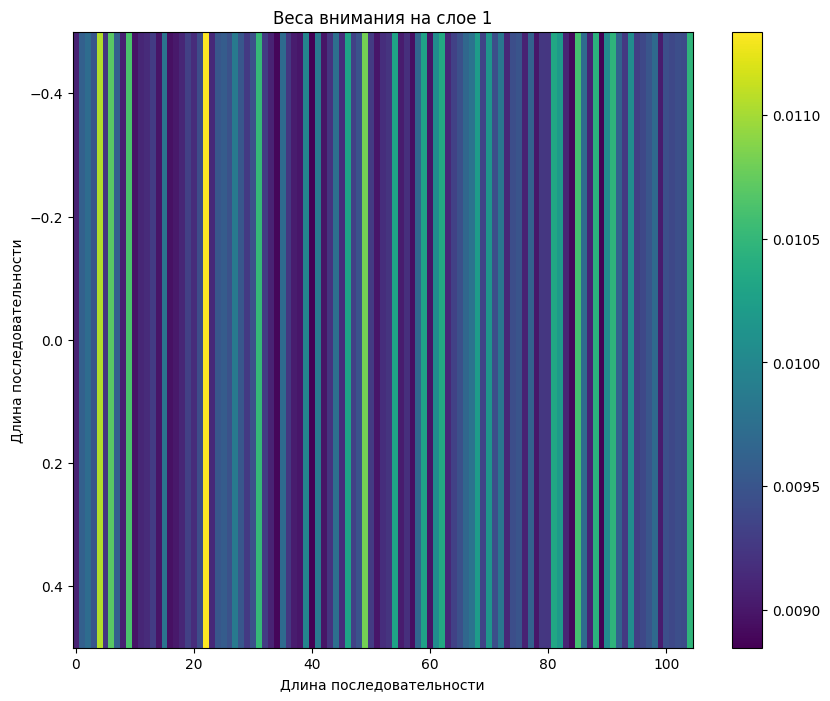

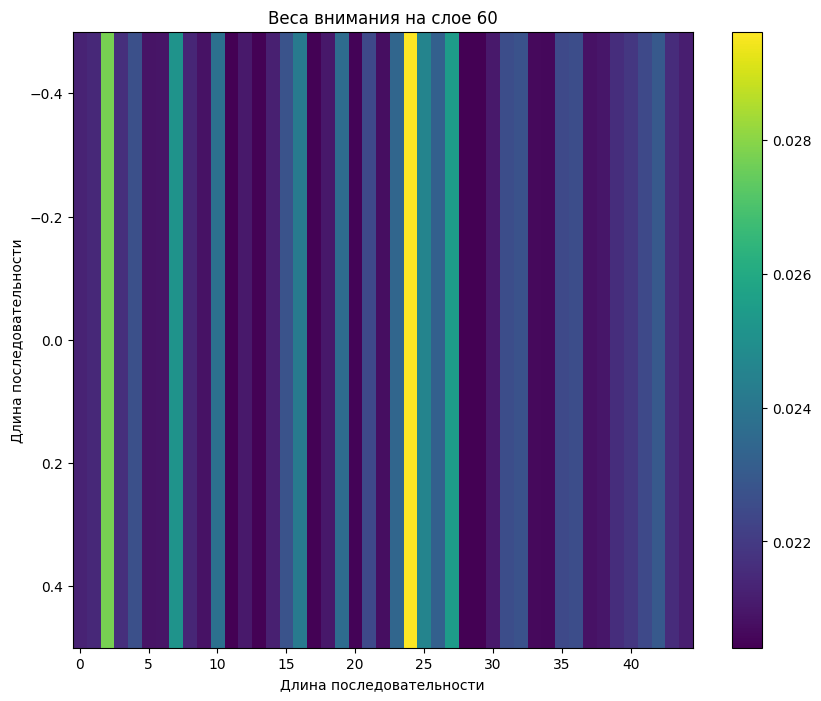

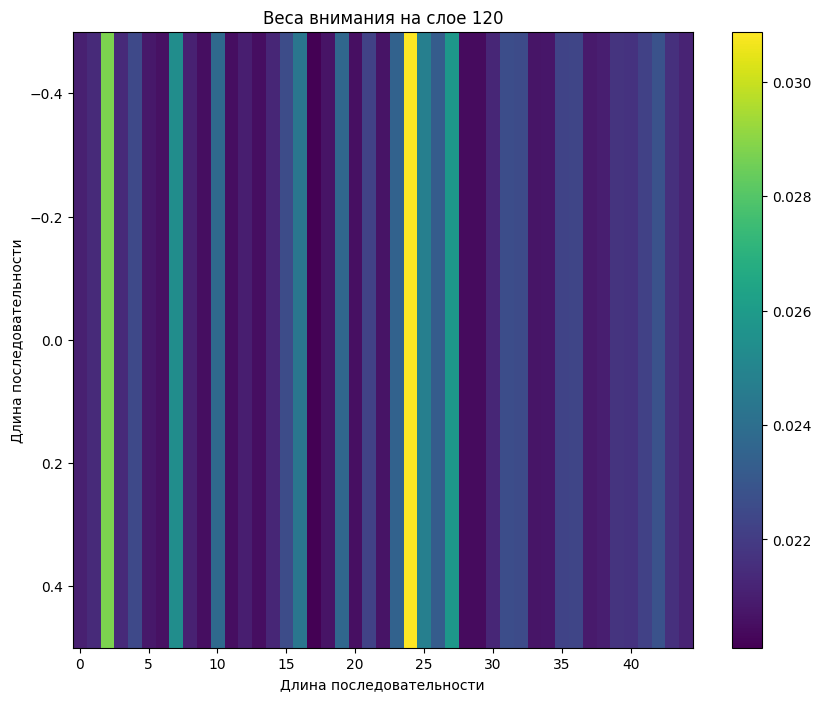

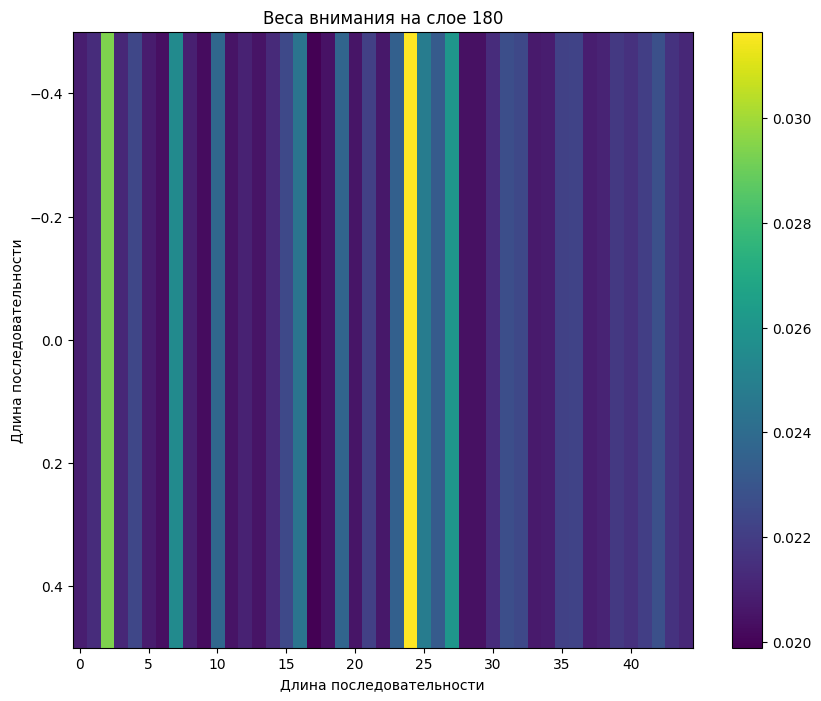

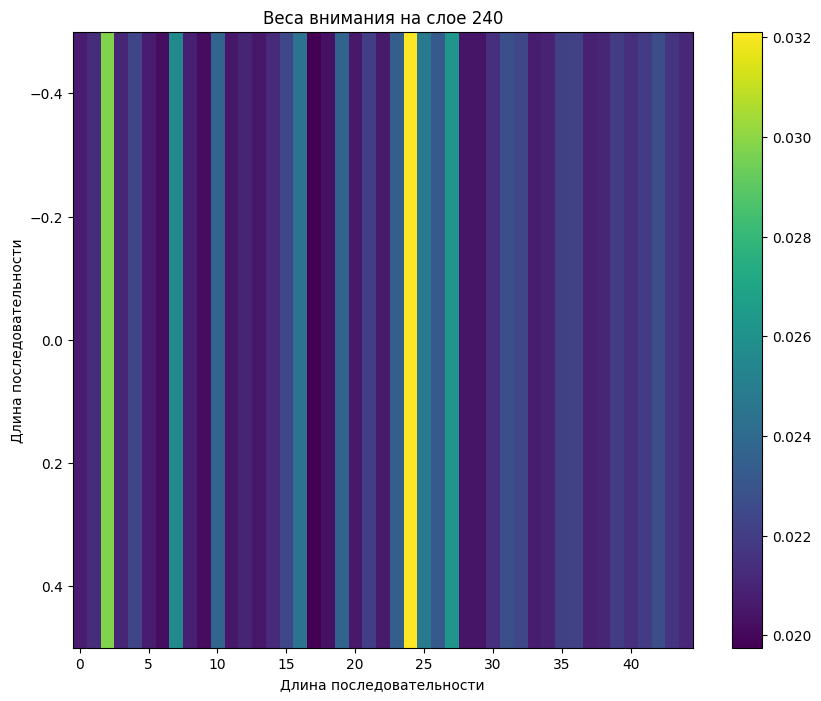

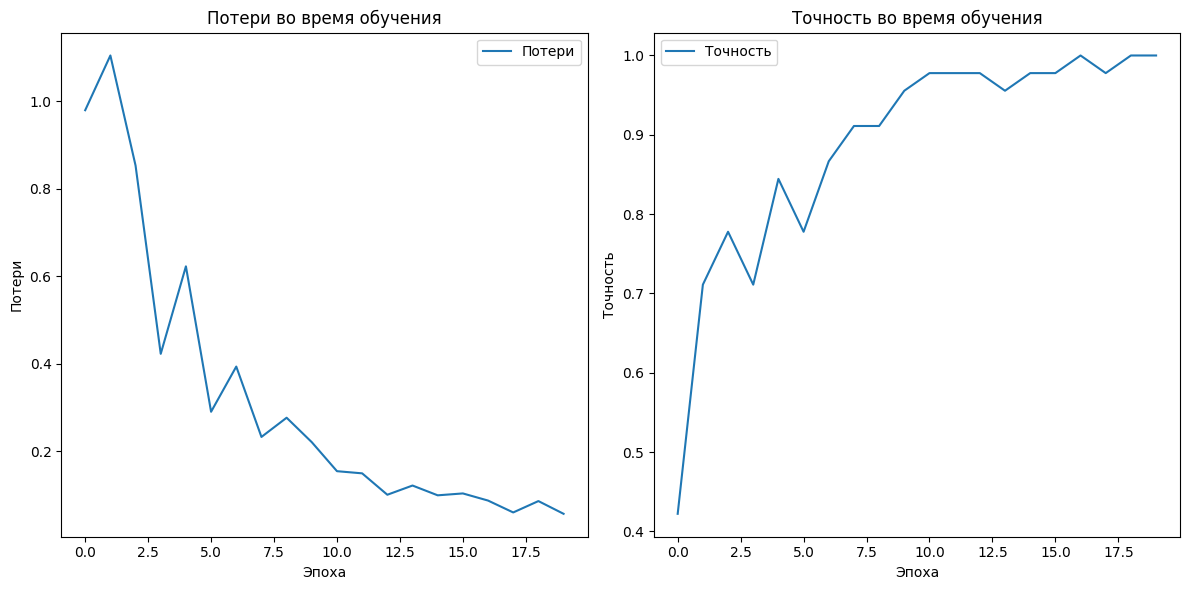

Финальная точность: 1.0000


In [9]:
# Определение модели трансформера с несколькими слоями
class TransformerModelWithAttention(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads = 8, num_layers = 6, hidden_dim = 256, dropout = 0.1):
        super(TransformerModelWithAttention, self).__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        # Позиционные кодировки, размерность фиксирована
        self.positional_encoding = nn.Parameter(torch.zeros(1, 100, hidden_dim)) # Длина последовательности 100 (или любая другая)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model = hidden_dim, nhead = num_heads, dim_feedforward = hidden_dim, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.attention_weights = []

    def forward(self, x):
        # Добавляем позиционные кодировки
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x = x + self.positional_encoding[:, :seq_len, :]
        
        # Пропускаем через трансформер
        encoder_output = self.transformer_encoder(x)
        
        # Извлечение внимания из каждого слоя трансформера
        for layer in self.transformer_encoder.layers:
            attention_output, attention_weights = layer.self_attn(x, x, x)
            self.attention_weights.append(attention_weights)
        
        x = encoder_output.mean(dim = 1) # Глобальное усреднение для классификации
        return self.fc_out(x)

# Загрузка данных Iris
iris = load_iris()
X = iris.data
y = iris.target

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)

# Преобразование в тензоры и добавление измерения последовательности (для модели трансформера)
X_train_tensor = torch.tensor(X_train, dtype = torch.float32).unsqueeze(1) # Добавление размерности последовательности
y_train_tensor = torch.tensor(y_train, dtype = torch.long)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

# Инициализация модели, оптимизатора и функции потерь
model = TransformerModelWithAttention(input_dim = 4, num_classes = 3)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# Функция для обучения модели с логированием потерь и точности
losses = []
accuracies = []

def train_with_logging(model, X_train, y_train, X_test, y_test, optimizer, criterion, epochs = 100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        accuracy = evaluate(model, X_test, y_test)
        accuracies.append(accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Эпоха {epoch+1}/{epochs}, Потери: {loss.item()}')

# Функция для оценки точности
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        _, predictions = torch.max(output, dim=1)
        accuracy = (predictions == y_test).float().mean()
    return accuracy.item()

# Обучение модели с логированием
train_with_logging(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, optimizer, criterion, epochs = 20)

# Визуализация внимания для 5 слоев
def plot_attention_weights(weights, layer):
    attention_weights = weights[layer]
    
    # Если веса внимания имеют больше чем 2 размерности, усредняем по головам
    if len(attention_weights.shape) > 2:
        attention_weights = attention_weights.mean(dim=1).squeeze().detach().numpy() # Усреднение по головам
    
    # Проверяем размерность после усреднения
    if attention_weights.ndim == 1:
        attention_weights = attention_weights[None, :] # Преобразование в двумерный массив (1, seq_len)
    
    plt.figure(figsize = (10, 8))
    plt.imshow(attention_weights, cmap = 'viridis', aspect = 'auto')
    plt.colorbar()
    plt.title(f"Веса внимания на слое {layer + 1}")
    plt.xlabel("Длина последовательности")
    plt.ylabel("Длина последовательности")
    plt.show()

# Количество графиков (5)
num_plots = 5
layers_to_plot = np.linspace(0, len(model.attention_weights) - 1, num_plots, dtype = int)

# Визуализация выбранных слоев
for i in layers_to_plot:
    plot_attention_weights(model.attention_weights, i)

# Визуализация графиков потерь и точности
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(losses, label = 'Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label = 'Точность')
plt.title('Точность во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

# Оценка модели на тестовых данных
accuracy = evaluate(model, X_test_tensor, y_test_tensor)
print(f'Финальная точность: {accuracy:.4f}')

## Домашнее задание: Обучение и визуализация трансформера

### Цель задания

1. Обучить простую модель трансформера для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
2. Визуализировать веса внимания и интерпретировать их
3. Сделать выводы о том, как модель воспринимает данные и принимает решения